In [24]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.plotting import plot_img, plot_stat_map, view_img
from nilearn.image import concat_imgs, mean_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.interfaces.fmriprep import load_confounds_strategy
from nilearn.image import resample_to_img
from scipy.interpolate import interp1d
from nilearn.maskers import NiftiMapsMasker, NiftiSpheresMasker
import seaborn as sns



# Homemade functions

In [3]:
# Now open a directory 
fd = os.open("/Users/luisalvarez/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the dir/folder
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets


In [56]:
def create_events_df(participant_raw_events, trials_num, TR):

    run1_events = pd.DataFrame(columns={"onset", "duration", "trial_type"}) 

    for x in range(trials_num): 

        trial_onset = participant_raw_events["onset"][x]
        anticipation_onset = trial_onset #+ TR/2
        anticipation_duration = 2

        response_onset = trial_onset + participant_raw_events["response_time"][x] #+ TR/2
        response_duration = 0.5

        outcome_lag = 7
        outcome_onset = trial_onset + outcome_lag #+ TR/2
        outcome_duration = 2

        current_trial = participant_raw_events["trial_type"][x]
        current_hit = participant_raw_events["hit"][x]
    
        # Determine event type for anticipation period.
        if(current_trial == "-$0"):
            current_trialtype = "nonloss"
            response_trial = "response"
        elif(current_trial == "+$0"):
            current_trialtype = "nongain"
            response_trial = "response"
        elif(current_trial == "+$5"):
            current_trialtype = "large_gain"
            response_trial = "response"
        elif(current_trial == "-$5"):
            current_trialtype = "large_loss"
            response_trial = "response"
        elif(current_trial == "+$1"):
            current_trialtype = "medium_gain"
            response_trial = "response"
        elif(current_trial == "-$1"):
            current_trialtype = "medium_loss"
            response_trial = "response"
        else:
            print(f"There appears to be an error with trial {x}")
    
        if(current_hit == 1):
            #current_trialtype = current_trialtype + "_hit"
            current_outcome_type = "outome_" + current_trialtype 
        else:
            #current_trialtype = current_trialtype + "_miss"
            current_outcome_type = "outome_zero" + "_miss"

        anticipation_data = [[anticipation_onset, anticipation_duration, current_trialtype]]
        current_row = pd.DataFrame(data=anticipation_data, columns=["onset", "duration", "trial_type"]) 
        run1_events = pd.concat([run1_events, current_row], ignore_index=True)

        if(current_hit == 1):
            response_data = [[response_onset, response_duration, response_trial]]
            response_row = pd.DataFrame(data=response_data, columns=["onset", "duration", "trial_type"]) 
            run1_events = pd.concat([run1_events, response_row], ignore_index=True)  
        

        current_outcome_row = pd.DataFrame(data=[[outcome_onset, outcome_duration, current_outcome_type]], columns=["onset", "duration", "trial_type"])
        run1_events = pd.concat([run1_events, current_outcome_row], ignore_index=True)

    return run1_events


In [5]:
def run_FL_GLM(participant_num):
    
    # Load files for sub 00X 
    current_sub_run1_func_file = "MID_preproc2/sub-" + participant_num +"/func/sub-" + participant_num + "_task-MID_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    current_sub_run1_mask_file = "MID_preproc2/sub-" + participant_num + "/func/sub-"+ participant_num +"_task-MID_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    current_sub_file = 'MID_raw/sub-' + participant_num + '/func/sub-' + participant_num + '_task-MID_run-1_events.tsv'
    current_sub_run1_confounds_file = "MID_preproc2/sub-" + participant_num + "/func/sub-" + participant_num + "_task-MID_run-1_desc-confounds_timeseries.tsv"

    # Get some info from the ".nii" file. 
    current_sub_func_file = nib.load(current_sub_run1_func_file)
    current_sub_func_data = current_sub_func_file.get_data()

    print("File of fist run 1 has shape (x, y, z, n_vols) -> %s" % str(current_sub_func_data.shape))

    """My understading is the doing this kind of resampling should be redundant. However, for some reason
    it seems to slightly improve the results for some subjects. Note, this signifincantly increases running time
    (e.g., without resampling it takes ~20 sec per subject, whereas with resampling it increases to ~5 min)"""
    # Resample func file to mni152_template 2mm. (NOT USED.)
    #template = load_mni152_template(resolution=2)
    #resampled_file = resample_to_img(current_sub_run1_func_file, template)
    
    # Load current participants responses file.
    current_sub_events_raw = pd.read_csv(current_sub_file, sep='\t')
    trials_num = current_sub_events_raw.shape[0]

    print(f"run1_events shape: {current_sub_events_raw.shape}")
    print(f"Run 1 number of trials: {trials_num}")

    # Create events dataframe.
    current_sub_events = create_events_df(current_sub_events_raw, trials_num, TR=2)
    print(f"Use the following event regressors: {current_sub_events.trial_type.unique()}")

    # Load raw confounds file. 
    current_sub_confounds_df = pd.read_csv(current_sub_run1_confounds_file, sep='\t')
    default_confounds = ['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', "global_signal", 
                         "tcompcor", "white_matter", "csf", "framewise_displacement", "dvars"] # "csf_wm", 

    # Get motion confounds.
    current_state_confounds = [i for i in current_sub_confounds_df.columns if "state" in i] 
    current_state_confounds = current_state_confounds[0:1]
    current_motion_confounds = [i for i in current_sub_confounds_df.columns if "motion" in i] 

    # Create confounds df.
    current_sub_confounds_df = current_sub_confounds_df[default_confounds + current_motion_confounds] #  + current_state_confounds
    current_sub_confounds_df = current_sub_confounds_df.fillna(0) 
    print(f"Use the following confound regressors: {current_sub_confounds_df.columns}")
    
    # Create First Level GLM object.
    fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model="ols",
    standardize=True,
    hrf_model="spm", 
    drift_model="cosine",
    high_pass= 0.011,
    slice_time_ref=0.5, 
    mask_img=current_sub_run1_mask_file,
    smoothing_fwhm=4)

    # Fit GLM object to participants data.
    fmri_glm = fmri_glm.fit(current_sub_run1_func_file, current_sub_events, current_sub_confounds_df)

    anticipation_gain_contrast = "+1*large_gain+1*medium_gain-2*nongain"
    #anticipation_gain_contrast = "+1*large_gain_hit+1*large_gain_miss+1*medium_gain_hit+1*medium_gain_miss-2*nongain_hit-2*nongain_miss"

    anticipation_gain_z_map = fmri_glm.compute_contrast(contrast_def=anticipation_gain_contrast, output_type="z_score")

    anticipation_gain_thresholded_map, threshold = threshold_stats_img(anticipation_gain_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)
    print(f"FDR p<0.05 threshold: {threshold:.3f}")
    plot_stat_map(
    anticipation_gain_thresholded_map,
    threshold=threshold,
    cut_coords=[15, 14, -5],
    black_bg=True,
    title=str("Participant " + participant_num + ": Gain vs. Nongain Anticipation"))
    plt.show()

    return fmri_glm

    
    

In [54]:
def getVolOnsets(participant_num):

    # Load files for sub 00X. 
    current_sub_func_file = "MID_preproc2/sub-" + participant_num +"/func/sub-" + participant_num + "_task-MID_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    current_sub_file = 'MID_raw/sub-' + participant_num + '/func/sub-' + participant_num + '_task-MID_run-1_events.tsv'

    # Calculate vol and time points. 
    # Load '.nii' file and get the shape/size of data. 
    func_file = nib.load(current_sub_func_file)
    func_data = func_file.get_data()
    n_vols = func_data.shape[3]
    TR = 2
    n_timepoints = n_vols*TR

    # Process raw events file. 
    # Load current participants responses file.
    current_sub_events_raw = pd.read_csv(current_sub_file, sep='\t')
    trials_num = current_sub_events_raw.shape[0]
    current_sub_events_df = create_events_df(current_sub_events_raw, trials_num, TR=2)

    # Obtain the time onsets from each event type.
    large_gain_onsets = np.array(current_sub_events_df[current_sub_events_df["trial_type"] == "large_gain"]["onset"]).astype(int)
    medium_gain_onsets = np.array(current_sub_events_df[current_sub_events_df["trial_type"] == "medium_gain"]["onset"]).astype(int)
    non_gain_onsets = np.array(current_sub_events_df[current_sub_events_df["trial_type"] == "nongain"]["onset"]).astype(int)

    # Down-sample time onsets to get vol onsets. 
    # Create array from 0 to n_timepoints in steps of 1. 
    time_scale = np.arange(0, n_timepoints, 1)  

    # Vector array of zeros of n_timepoints length.
    large_gain_time_onsets = np.zeros(n_timepoints)
    medium_gain_time_onsets = np.zeros(n_timepoints)
    non_gain_time_onsets = np.zeros(n_timepoints)

    # Assign 1's to onsets of stimuli. 
    large_gain_time_onsets[large_gain_onsets] = 1
    medium_gain_time_onsets[medium_gain_onsets] = 1
    non_gain_time_onsets[non_gain_onsets] = 1

    # Create resampler objects. 
    resampler_lg = interp1d(time_scale, large_gain_time_onsets)
    resampler_mg = interp1d(time_scale, medium_gain_time_onsets)
    resampler_ng = interp1d(time_scale, non_gain_time_onsets)

    # Create array from 0 to n_timepoints in steps of TR=2.    
    vol_scale = np.arange(0, n_timepoints, TR)  

    # Resample onsets in time to vol.
    large_gain_vol_onsets = resampler_lg(vol_scale)
    medium_gain_vol_onsets = resampler_mg(vol_scale)
    non_gain_vol_onsets = resampler_ng(vol_scale)

    return large_gain_vol_onsets, medium_gain_vol_onsets, non_gain_vol_onsets

In [70]:
def getTimeCourses(participant_num, large_gain_onsets, medium_gain_onsets, non_gain_onsets):

    # Load files for sub 00X 
    current_sub_run1_func_file = "MID_preproc2/sub-" + participant_num +"/func/sub-" + participant_num + "_task-MID_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    current_sub_run1_confounds_file = "MID_preproc2/sub-" + participant_num + "/func/sub-" + participant_num + "_task-MID_run-1_desc-confounds_timeseries.tsv"

    # Load raw confounds file. 
    current_sub_confounds_df = pd.read_csv(current_sub_run1_confounds_file, sep='\t')
    default_confounds = ['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', "global_signal", 
                         "tcompcor", "white_matter", "csf", "framewise_displacement", "dvars"] 

    # Get motion confounds.
    current_motion_confounds = [i for i in current_sub_confounds_df.columns if "motion" in i] 

    # Create confounds df (defaul + motion confounds).
    current_sub_confounds_df = current_sub_confounds_df[default_confounds + current_motion_confounds] 
    current_sub_confounds_df = current_sub_confounds_df.fillna(0) 

    # Create Sphere Mask object. 
    masker_sNAcc = NiftiSpheresMasker(
    seeds=[(10, 12, -2), (-10, 12, -2)],  # (right, left)
    radius=8, 
    standardize="zscore",  
    t_r=2,
    standardize_confounds=True,
    high_pass=0.011,
    low_pass=0.1)

    # Mask the epi data and get a time series for the ROI
    bold_sNAcc = masker_sNAcc.fit_transform(current_sub_run1_func_file, confounds=current_sub_confounds_df)
    
    # Extract segments around stimulus onsets for condition 1
    bold_sNAcc_lg_bi = np.array([np.mean(bold_sNAcc[idx - 2: idx + 8][:, 1:2], axis=1) for idx in range(large_gain_onsets.shape[0]) if (large_gain_onsets[idx] > 0) and (large_gain_onsets[idx + 4] <= len(bold_sNAcc))])

    # Extract segments around stimulus onsets for condition 2
    bold_sNAcc_mg_bi = np.array([np.mean(bold_sNAcc[idx - 2: idx + 8][:, 1:2], axis=1) for idx in range(medium_gain_onsets.shape[0]) if (medium_gain_onsets[idx] > 0) and (medium_gain_onsets[idx + 4] <= len(bold_sNAcc))])

    # Extract segments around stimulus onsets for condition 3
    bold_sNAcc_ng_bi = np.array([np.mean(bold_sNAcc[idx - 2: idx + 8][:, 1:2], axis=1) for idx in range(non_gain_onsets.shape[0]) if (non_gain_onsets[idx] > 0) and (non_gain_onsets[idx + 4] <= len(bold_sNAcc))])

    return bold_sNAcc_lg_bi, bold_sNAcc_mg_bi, bold_sNAcc_ng_bi





In [76]:
def plot_timecourses(participant_num, bold_sNAcc_lg_bi, bold_sNAcc_mg_bi, bold_sNAcc_ng_bi):

    # Create a list of event categories and stimuli
    event_categories = ["Large_gain", "Medium_gain", "Non_gain"]
    stimuli = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    signal_array = np.array([bold_sNAcc_lg_bi, bold_sNAcc_mg_bi, bold_sNAcc_ng_bi])

    # Initialize empty lists to store data
    timepoints = []
    events = []
    stimulus_list = []
    signals = []

    for event_category in range(3):
        for stimulus in range(0, 12):
            for timepoint in range(0, 10):  # Assuming 10 timepoints
                timepoints.append(timepoint)
                events.append(event_categories[event_category])
                stimulus_list.append(str(event_categories[event_category] + stimuli[stimulus]))
                signals.append(signal_array[event_category, stimulus, timepoint])

    # Create the DataFrame
    data = {
        'TR': timepoints,
        'event': events,
        'stimulus': stimulus_list,
        'Z-score': signals
        }

    bold_sNAcc_bi_df = pd.DataFrame(data)
    
    g = sns.relplot(data=bold_sNAcc_bi_df, x="TR", y="Z-score", hue="event", kind="line", height=4, aspect=1.7)
    g.fig.suptitle(str("Sub" + participant_num + " bilateral NAcc anticipatory activity for all rewards"), fontsize=12)
    #g.add_legend(title=str("Sub" + participant_num + " bilateral NAcc anticipatory activity for all rewards"))


# First Level Models 

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_25805/2226020054.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape (x, y, z, n_vols) -> (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'outome_zero_miss' 'medium_loss' 'response'
 'outome_medium_loss' 'nongain' 'outome_nongain' 'large_gain' 'large_loss'
 'outome_large_loss' 'medium_gain' 'outome_medium_gain' 'outome_nonloss'
 'outome_large_gain']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z',
       'global_signal', 'tcompcor', 'white_matter', 'csf',
       'framewise_displacement', 'dvars', 'motion_outlier00',
       'motion_outlier01', 'motion_outlier02', 'motion_outlier03'],
      dtype='object')
FDR p<0.05 threshold: 3.041


/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


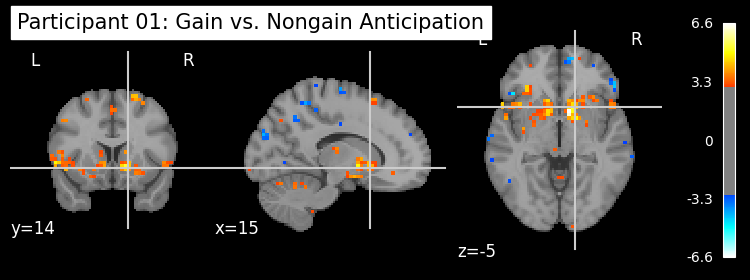

In [6]:
glms_list = []
glms_list.append(run_FL_GLM("01"))

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_25805/3420944008.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  func_data = func_file.get_data()


(3, 12, 10)


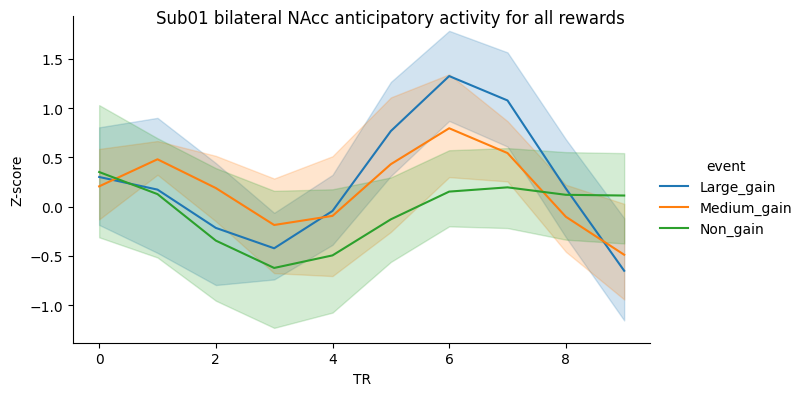

In [71]:
large_gain_vol_onsets01, medium_gain_vol_onsets01, non_gain_vol_onsets01 = getVolOnsets("01")
bold_sNAcc_lg_bi_01, bold_sNAcc_mg_bi_01, bold_sNAcc_ng_bi_01 = getTimeCourses("01", large_gain_vol_onsets01, medium_gain_vol_onsets01, non_gain_vol_onsets01)
plot_timecourses("01", bold_sNAcc_lg_bi_01, bold_sNAcc_mg_bi_01, bold_sNAcc_ng_bi_01)



/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_25805/2226020054.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape (x, y, z, n_vols) -> (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'response' 'outome_nonloss' 'medium_loss' 'outome_medium_loss'
 'nongain' 'outome_nongain' 'large_gain' 'outome_large_gain'
 'outome_zero_miss' 'large_loss' 'outome_large_loss' 'medium_gain'
 'outome_medium_gain']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z',
       'global_signal', 'tcompcor', 'white_matter', 'csf',
       'framewise_displacement', 'dvars', 'motion_outlier00',
       'motion_outlier01', 'motion_outlier02', 'motion_outlier03',
       'motion_outlier04'],
      dtype='object')
FDR p<0.05 threshold: 3.103


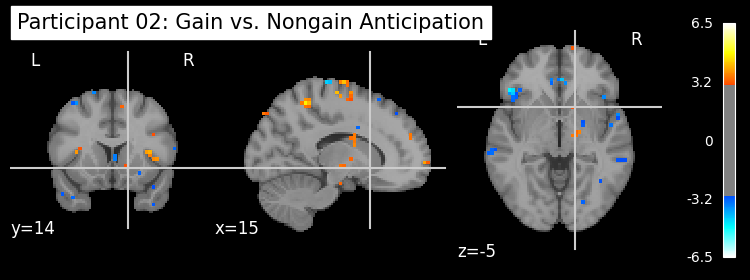

In [7]:
glms_list.append(run_FL_GLM("02"))

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_25805/3420944008.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  func_data = func_file.get_data()


(3, 12, 10)


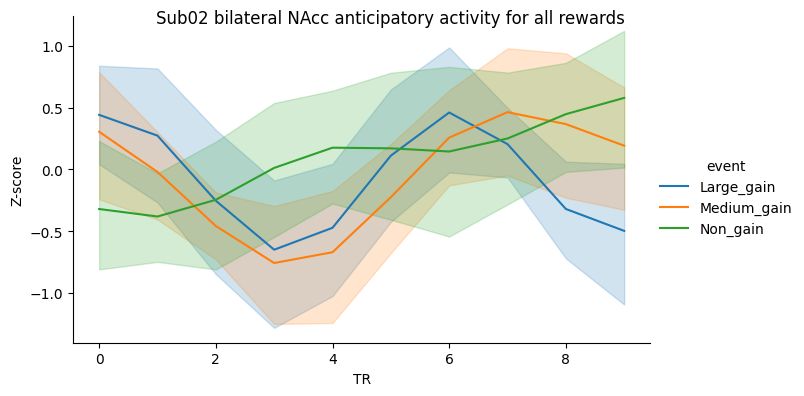

In [72]:
large_gain_vol_onsets02, medium_gain_vol_onsets02, non_gain_vol_onsets02 = getVolOnsets("02")
bold_sNAcc_lg_bi_02, bold_sNAcc_mg_bi_02, bold_sNAcc_ng_bi_02 = getTimeCourses("02", large_gain_vol_onsets02, medium_gain_vol_onsets02, non_gain_vol_onsets02)
plot_timecourses("02", bold_sNAcc_lg_bi_02, bold_sNAcc_mg_bi_02, bold_sNAcc_ng_bi_02)

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_25805/2226020054.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape (x, y, z, n_vols) -> (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'response' 'outome_nonloss' 'medium_loss' 'outome_medium_loss'
 'nongain' 'outome_nongain' 'large_gain' 'outome_zero_miss' 'large_loss'
 'medium_gain' 'outome_medium_gain' 'outome_large_gain'
 'outome_large_loss']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z',
       'global_signal', 'tcompcor', 'white_matter', 'csf',
       'framewise_displacement', 'dvars', 'motion_outlier00',
       'motion_outlier01'],
      dtype='object')
FDR p<0.05 threshold: 3.203


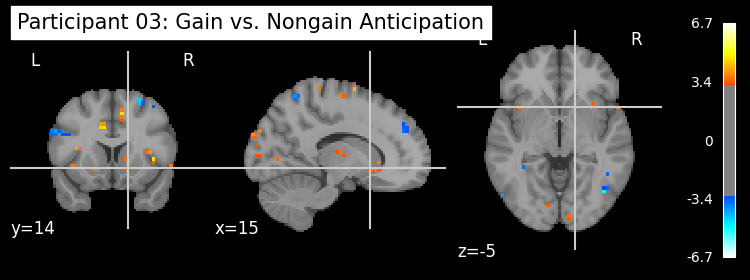

In [8]:
glms_list.append(run_FL_GLM("03"))

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_25805/3420944008.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  func_data = func_file.get_data()


(3, 12, 10)


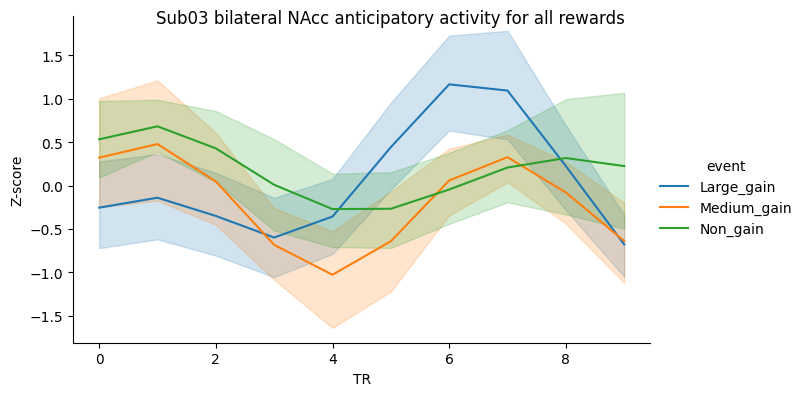

In [73]:
large_gain_vol_onsets03, medium_gain_vol_onsets03, non_gain_vol_onsets03 = getVolOnsets("03")
bold_sNAcc_lg_bi_03, bold_sNAcc_mg_bi_03, bold_sNAcc_ng_bi_03 = getTimeCourses("03", large_gain_vol_onsets03, medium_gain_vol_onsets03, non_gain_vol_onsets03)
plot_timecourses("03", bold_sNAcc_lg_bi_03, bold_sNAcc_mg_bi_03, bold_sNAcc_ng_bi_03)

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_25805/2226020054.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape (x, y, z, n_vols) -> (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'outome_zero_miss' 'medium_loss' 'response'
 'outome_medium_loss' 'nongain' 'outome_nongain' 'large_gain'
 'outome_large_gain' 'large_loss' 'outome_large_loss' 'medium_gain'
 'outome_medium_gain' 'outome_nonloss']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z',
       'global_signal', 'tcompcor', 'white_matter', 'csf',
       'framewise_displacement', 'dvars', 'motion_outlier00',
       'motion_outlier01', 'motion_outlier02', 'motion_outlier03',
       'motion_outlier04'],
      dtype='object')
FDR p<0.05 threshold: 3.020


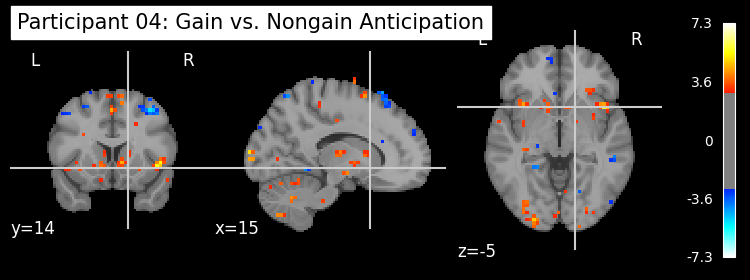

In [9]:
glms_list.append(run_FL_GLM("04"))

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_25805/3420944008.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  func_data = func_file.get_data()


(3, 12, 10)


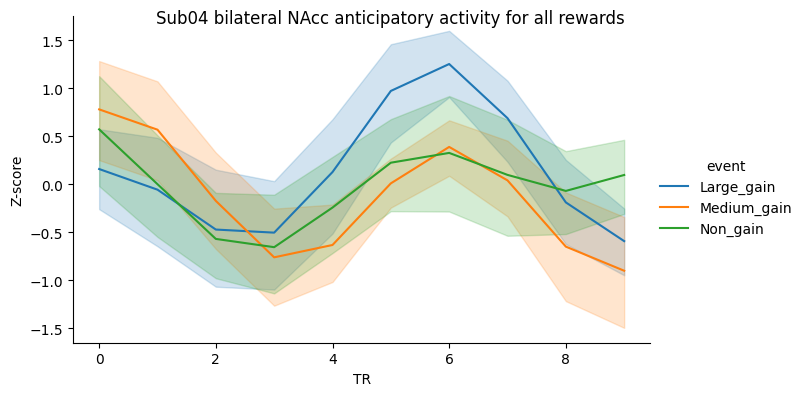

In [74]:
large_gain_vol_onsets04, medium_gain_vol_onsets04, non_gain_vol_onsets04 = getVolOnsets("04")
bold_sNAcc_lg_bi_04, bold_sNAcc_mg_bi_04, bold_sNAcc_ng_bi_04 = getTimeCourses("04", large_gain_vol_onsets04, medium_gain_vol_onsets04, non_gain_vol_onsets04)
plot_timecourses("04", bold_sNAcc_lg_bi_04, bold_sNAcc_mg_bi_04, bold_sNAcc_ng_bi_04)

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_25805/2226020054.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape (x, y, z, n_vols) -> (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'response' 'outome_nonloss' 'medium_loss' 'outome_medium_loss'
 'nongain' 'outome_nongain' 'large_gain' 'outome_large_gain' 'large_loss'
 'outome_large_loss' 'medium_gain' 'outome_medium_gain' 'outome_zero_miss']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z',
       'global_signal', 'tcompcor', 'white_matter', 'csf',
       'framewise_displacement', 'dvars', 'motion_outlier00',
       'motion_outlier01', 'motion_outlier02', 'motion_outlier03',
       'motion_outlier04'],
      dtype='object')
FDR p<0.05 threshold: 2.594


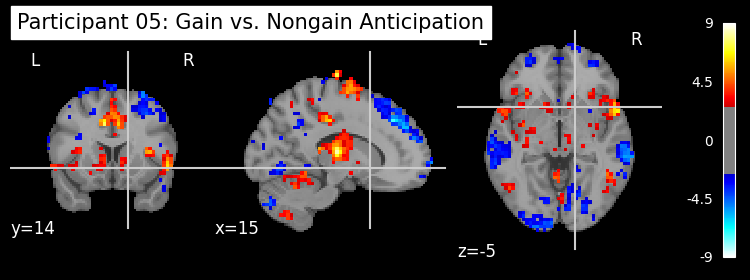

In [10]:
glms_list.append(run_FL_GLM("05"))

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_25805/3420944008.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  func_data = func_file.get_data()


(3, 12, 10)


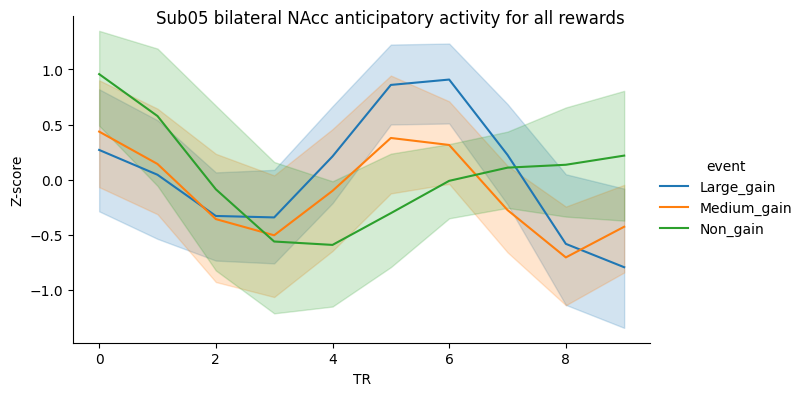

In [75]:
large_gain_vol_onsets05, medium_gain_vol_onsets05, non_gain_vol_onsets05 = getVolOnsets("05")
bold_sNAcc_lg_bi_05, bold_sNAcc_mg_bi_05, bold_sNAcc_ng_bi_05 = getTimeCourses("05", large_gain_vol_onsets05, medium_gain_vol_onsets05, non_gain_vol_onsets05)
plot_timecourses("05", bold_sNAcc_lg_bi_05, bold_sNAcc_mg_bi_05, bold_sNAcc_ng_bi_05)

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_25805/2226020054.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape (x, y, z, n_vols) -> (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'response' 'outome_nonloss' 'medium_loss' 'outome_medium_loss'
 'nongain' 'outome_nongain' 'large_gain' 'outome_large_gain' 'large_loss'
 'outome_large_loss' 'medium_gain' 'outome_medium_gain' 'outome_zero_miss']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z',
       'global_signal', 'tcompcor', 'white_matter', 'csf',
       'framewise_displacement', 'dvars', 'motion_outlier00',
       'motion_outlier01', 'motion_outlier02', 'motion_outlier03',
       'motion_outlier04', 'motion_outlier05', 'motion_outlier06',
       'motion_outlier07', 'motion_outlier08', 'motion_outlier09',
       'motion_outlier10'],
      dtype='object')
FDR p<0.05 threshold: 2.745


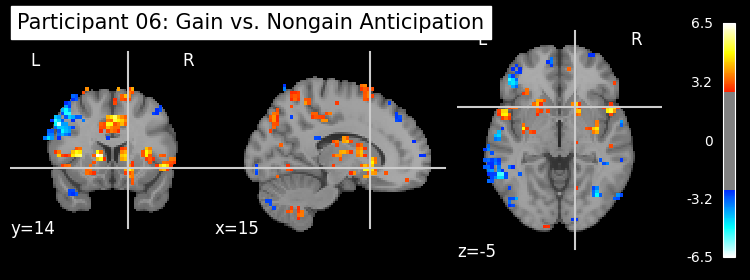

In [11]:
glms_list.append(run_FL_GLM("06"))

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_25805/2226020054.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape (x, y, z, n_vols) -> (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'response' 'outome_nonloss' 'medium_loss' 'outome_medium_loss'
 'nongain' 'outome_zero_miss' 'large_gain' 'outome_large_gain'
 'outome_nongain' 'large_loss' 'outome_large_loss' 'medium_gain'
 'outome_medium_gain']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z',
       'global_signal', 'tcompcor', 'white_matter', 'csf',
       'framewise_displacement', 'dvars', 'motion_outlier00',
       'motion_outlier01', 'motion_outlier02', 'motion_outlier03',
       'motion_outlier04', 'motion_outlier05'],
      dtype='object')
FDR p<0.05 threshold: 3.906


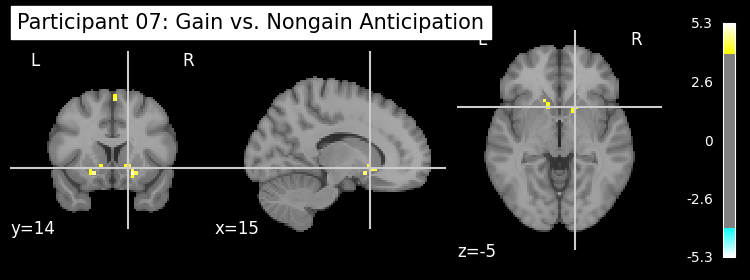

In [12]:
# Improves with -TR/2. Also leaving onsets untouched. 
glms_list.append(run_FL_GLM("07"))

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_25805/2226020054.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape (x, y, z, n_vols) -> (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'response' 'outome_nonloss' 'medium_loss' 'outome_medium_loss'
 'nongain' 'outome_nongain' 'large_gain' 'outome_large_gain'
 'outome_zero_miss' 'large_loss' 'outome_large_loss' 'medium_gain'
 'outome_medium_gain']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z',
       'global_signal', 'tcompcor', 'white_matter', 'csf',
       'framewise_displacement', 'dvars', 'motion_outlier00',
       'motion_outlier01'],
      dtype='object')
FDR p<0.05 threshold: 2.705


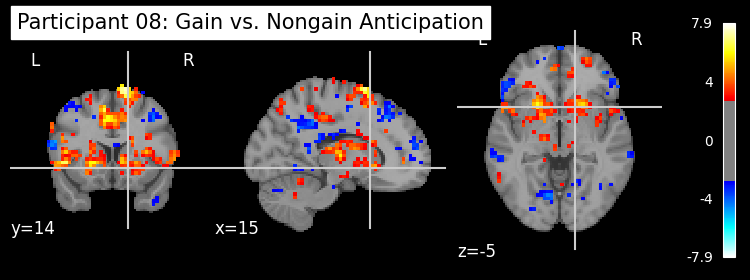

In [13]:
glms_list.append(run_FL_GLM("08"))

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_25805/2226020054.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape (x, y, z, n_vols) -> (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'outome_zero_miss' 'medium_loss' 'response'
 'outome_medium_loss' 'nongain' 'outome_nongain' 'large_gain'
 'outome_large_gain' 'large_loss' 'outome_large_loss' 'medium_gain'
 'outome_medium_gain' 'outome_nonloss']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z',
       'global_signal', 'tcompcor', 'white_matter', 'csf',
       'framewise_displacement', 'dvars', 'motion_outlier00',
       'motion_outlier01', 'motion_outlier02'],
      dtype='object')
FDR p<0.05 threshold: 2.612


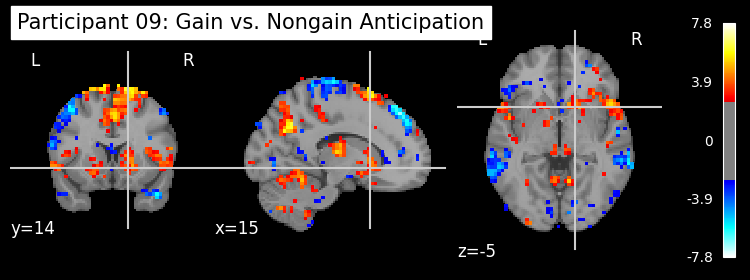

In [14]:
glms_list.append(run_FL_GLM("09"))

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_25805/2226020054.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape (x, y, z, n_vols) -> (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'outome_zero_miss' 'medium_loss' 'response'
 'outome_medium_loss' 'nongain' 'outome_nongain' 'large_gain'
 'outome_large_gain' 'large_loss' 'medium_gain' 'outome_medium_gain'
 'outome_nonloss' 'outome_large_loss']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z',
       'global_signal', 'tcompcor', 'white_matter', 'csf',
       'framewise_displacement', 'dvars', 'motion_outlier00',
       'motion_outlier01'],
      dtype='object')
FDR p<0.05 threshold: 3.210


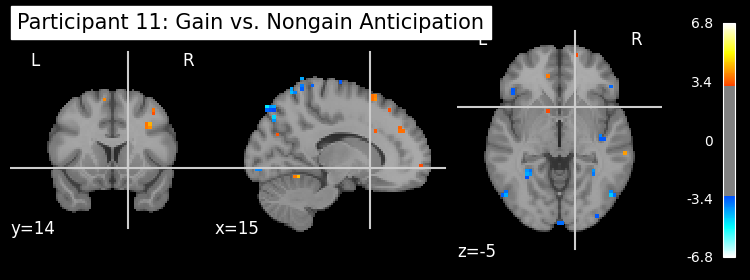

In [15]:
glms_list.append(run_FL_GLM("11"))

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_25805/2226020054.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  current_sub_func_data = current_sub_func_file.get_data()


File of fist run 1 has shape (x, y, z, n_vols) -> (58, 69, 58, 442)
run1_events shape: (72, 9)
Run 1 number of trials: 72
Use the following event regressors: ['nonloss' 'response' 'outome_nonloss' 'medium_loss' 'outome_medium_loss'
 'nongain' 'outome_zero_miss' 'large_gain' 'outome_large_gain'
 'outome_nongain' 'large_loss' 'outome_large_loss' 'medium_gain'
 'outome_medium_gain']
Use the following confound regressors: Index(['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z',
       'global_signal', 'tcompcor', 'white_matter', 'csf',
       'framewise_displacement', 'dvars', 'motion_outlier00',
       'motion_outlier01', 'motion_outlier02', 'motion_outlier03',
       'motion_outlier04', 'motion_outlier05', 'motion_outlier06'],
      dtype='object')
FDR p<0.05 threshold: 3.692


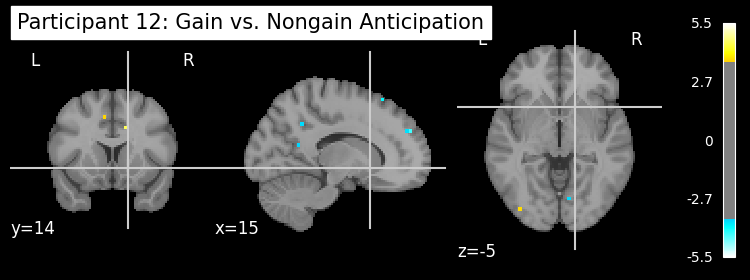

In [16]:
glms_list.append(run_FL_GLM("12"))

# Second Level Model

In [17]:
SecondLevelGLM = SecondLevelModel()
SecondLevelGLM.fit(glms_list)  

SecondLevelModel()

FDR p<0.05 threshold: 3.267


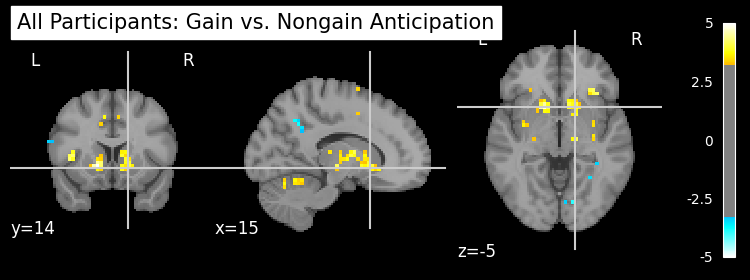

In [19]:
anticipation_gain_all = SecondLevelGLM.compute_contrast(first_level_contrast="+1*large_gain+1*medium_gain-2*nongain", output_type='z_score')

anticipation_gain_thresholded_map, threshold = threshold_stats_img(anticipation_gain_all, alpha=0.05, height_control="fdr", cluster_threshold=0)

print(f"FDR p<0.05 threshold: {threshold:.3f}")

plot_stat_map(anticipation_gain_thresholded_map,
    threshold=threshold,
    cut_coords=[15, 14, -5],
    black_bg=True,
    title=str("All Participants: Gain vs. Nongain Anticipation"))
plt.show()